In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%cd '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7'

/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7


In [ ]:
!git clone https://github.com/augmentedstartups/yolov7.git

fatal: destination path 'yolov7' already exists and is not an empty directory.


In [ ]:
%cd '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7'
!pip install -r requirements.txt
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="vhBk7rlPAH0i3qiDMMpp")
project = rf.workspace("hung-minh-nguyen").project("mask_detection_yolo_v7")
dataset = project.version(2).download("yolov7")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mask_Detection_YOLO_v7-2 in yolov7pytorch:: 100%|██████████| 5935/5935 [00:33<00:00, 174.88it/s]


In [ ]:
# Download pretrain model
%%bash
wget -P /content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7 https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [ ]:
#Training model
!python train.py --batch 16 --cfg cfg/training/yolov7.yaml --epochs 55 --data Mask_Detection_YOLO_v7-2/data.yaml --weights 'yolov7.pt' --device 0

YOLOR 🚀 v0.1-104-g941b94c torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7.yaml', data='Mask_Detection_YOLO_v7-2/data.yaml', device='0', entity=None, epochs=55, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov7.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bia

### Evaluate

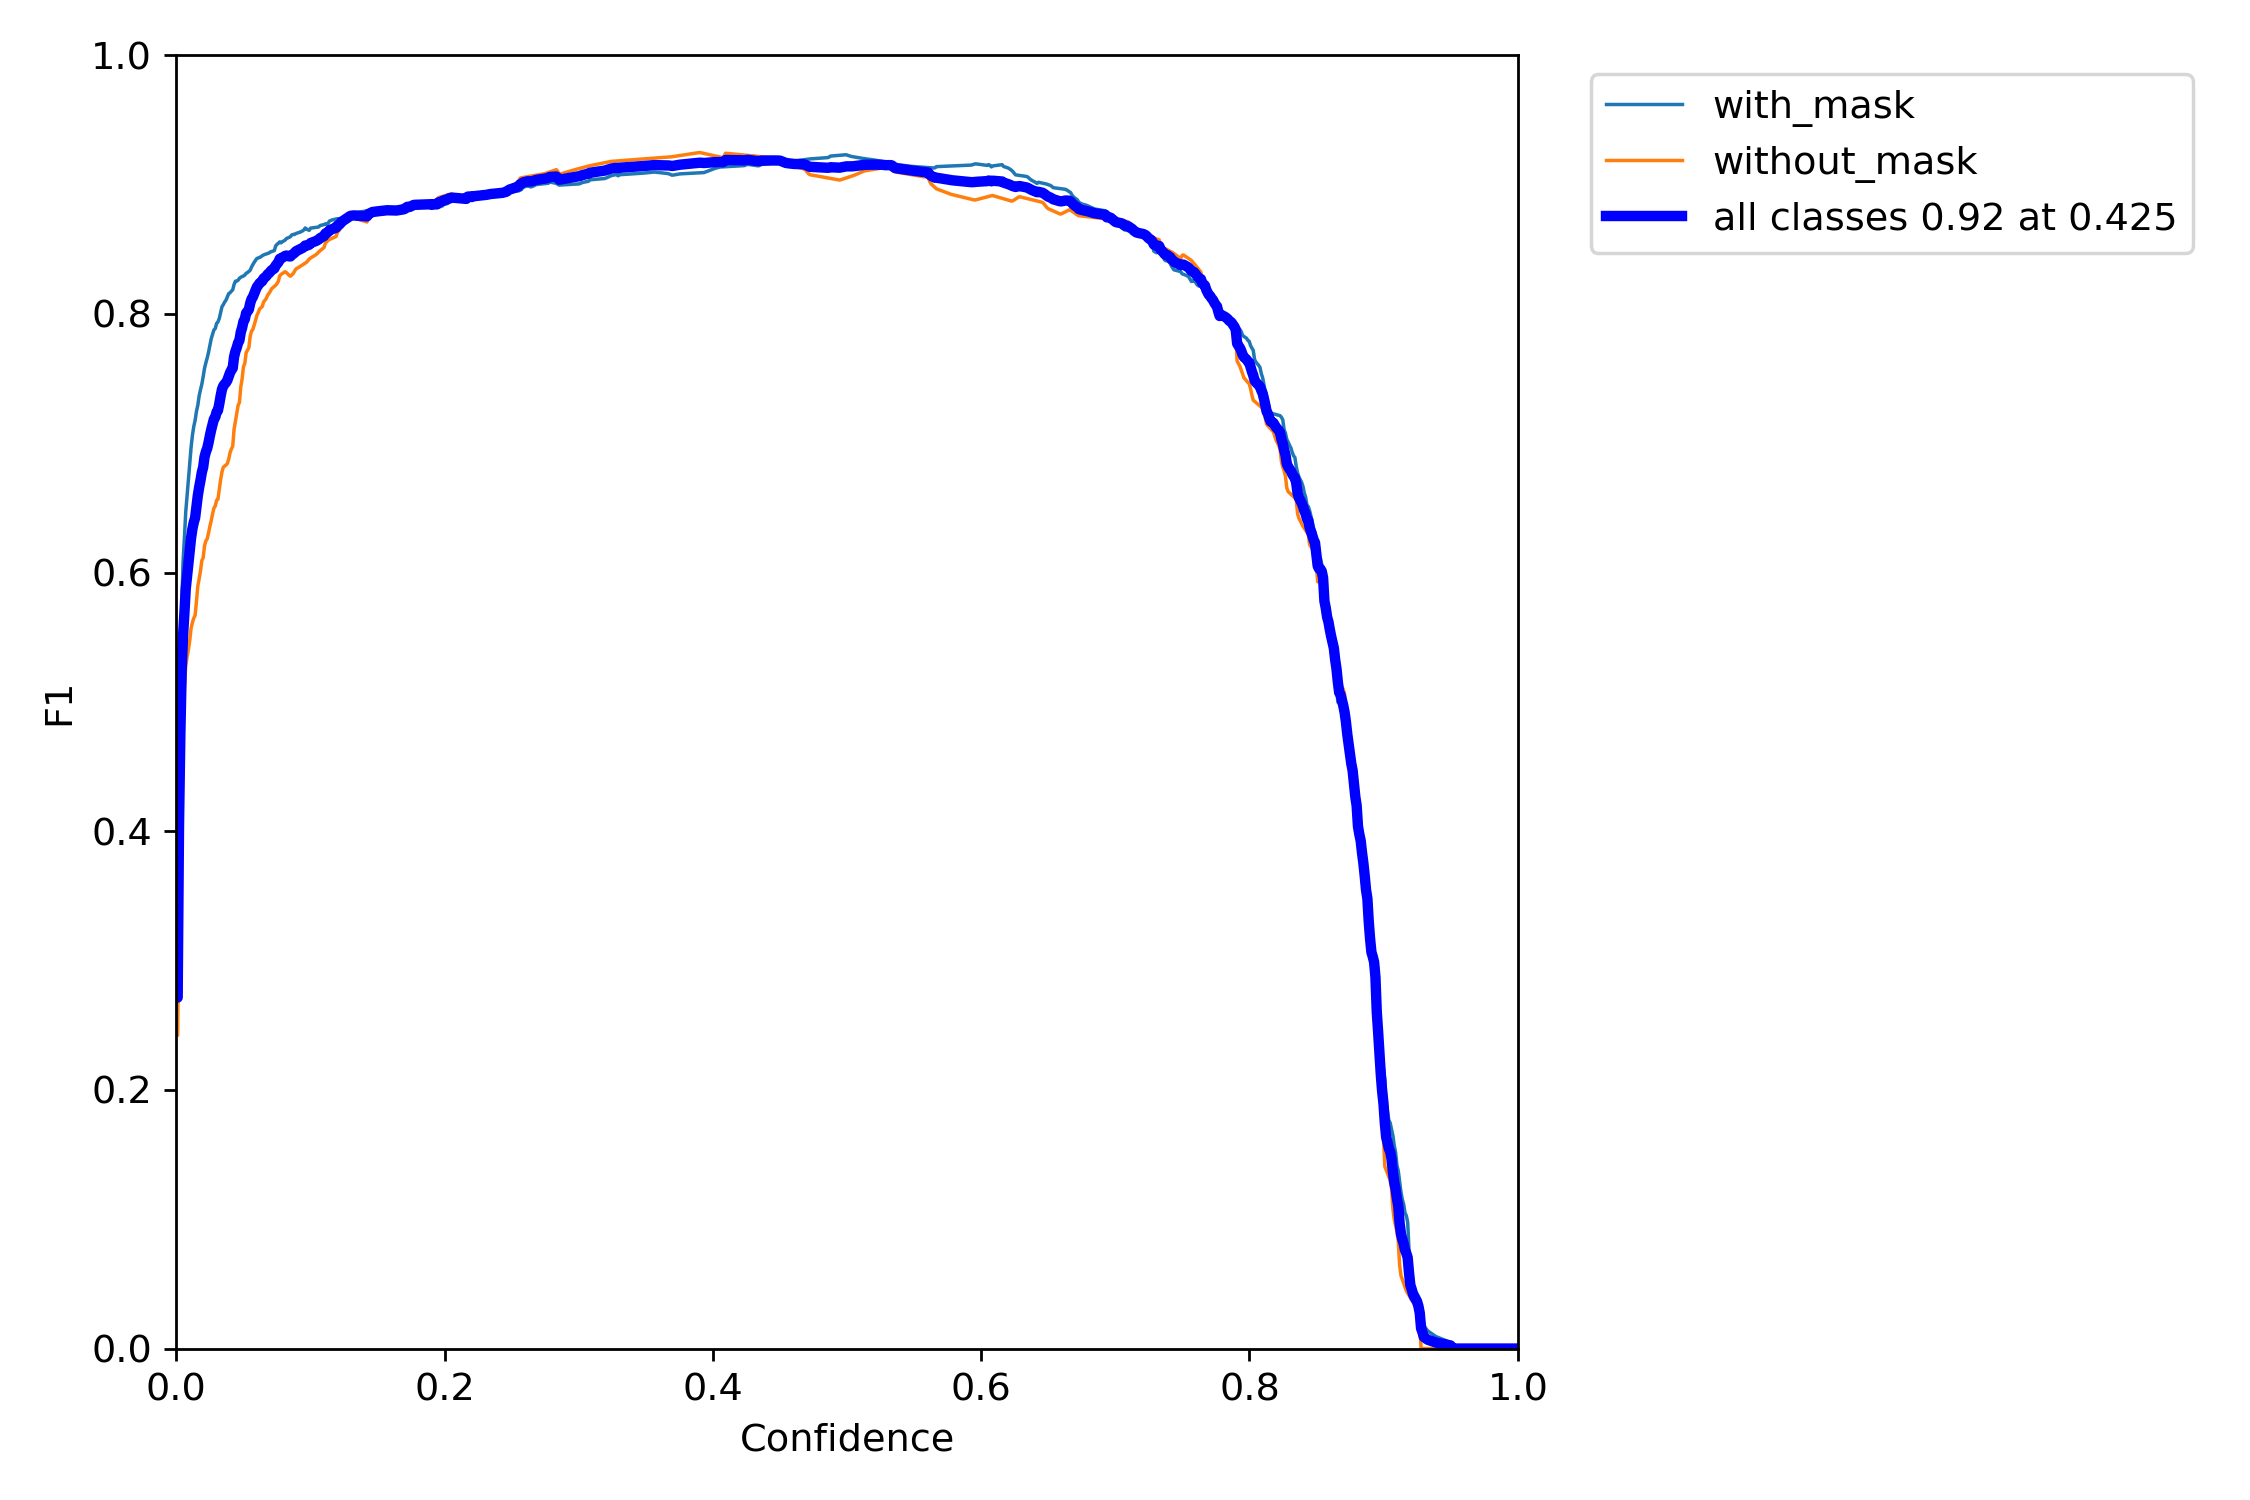

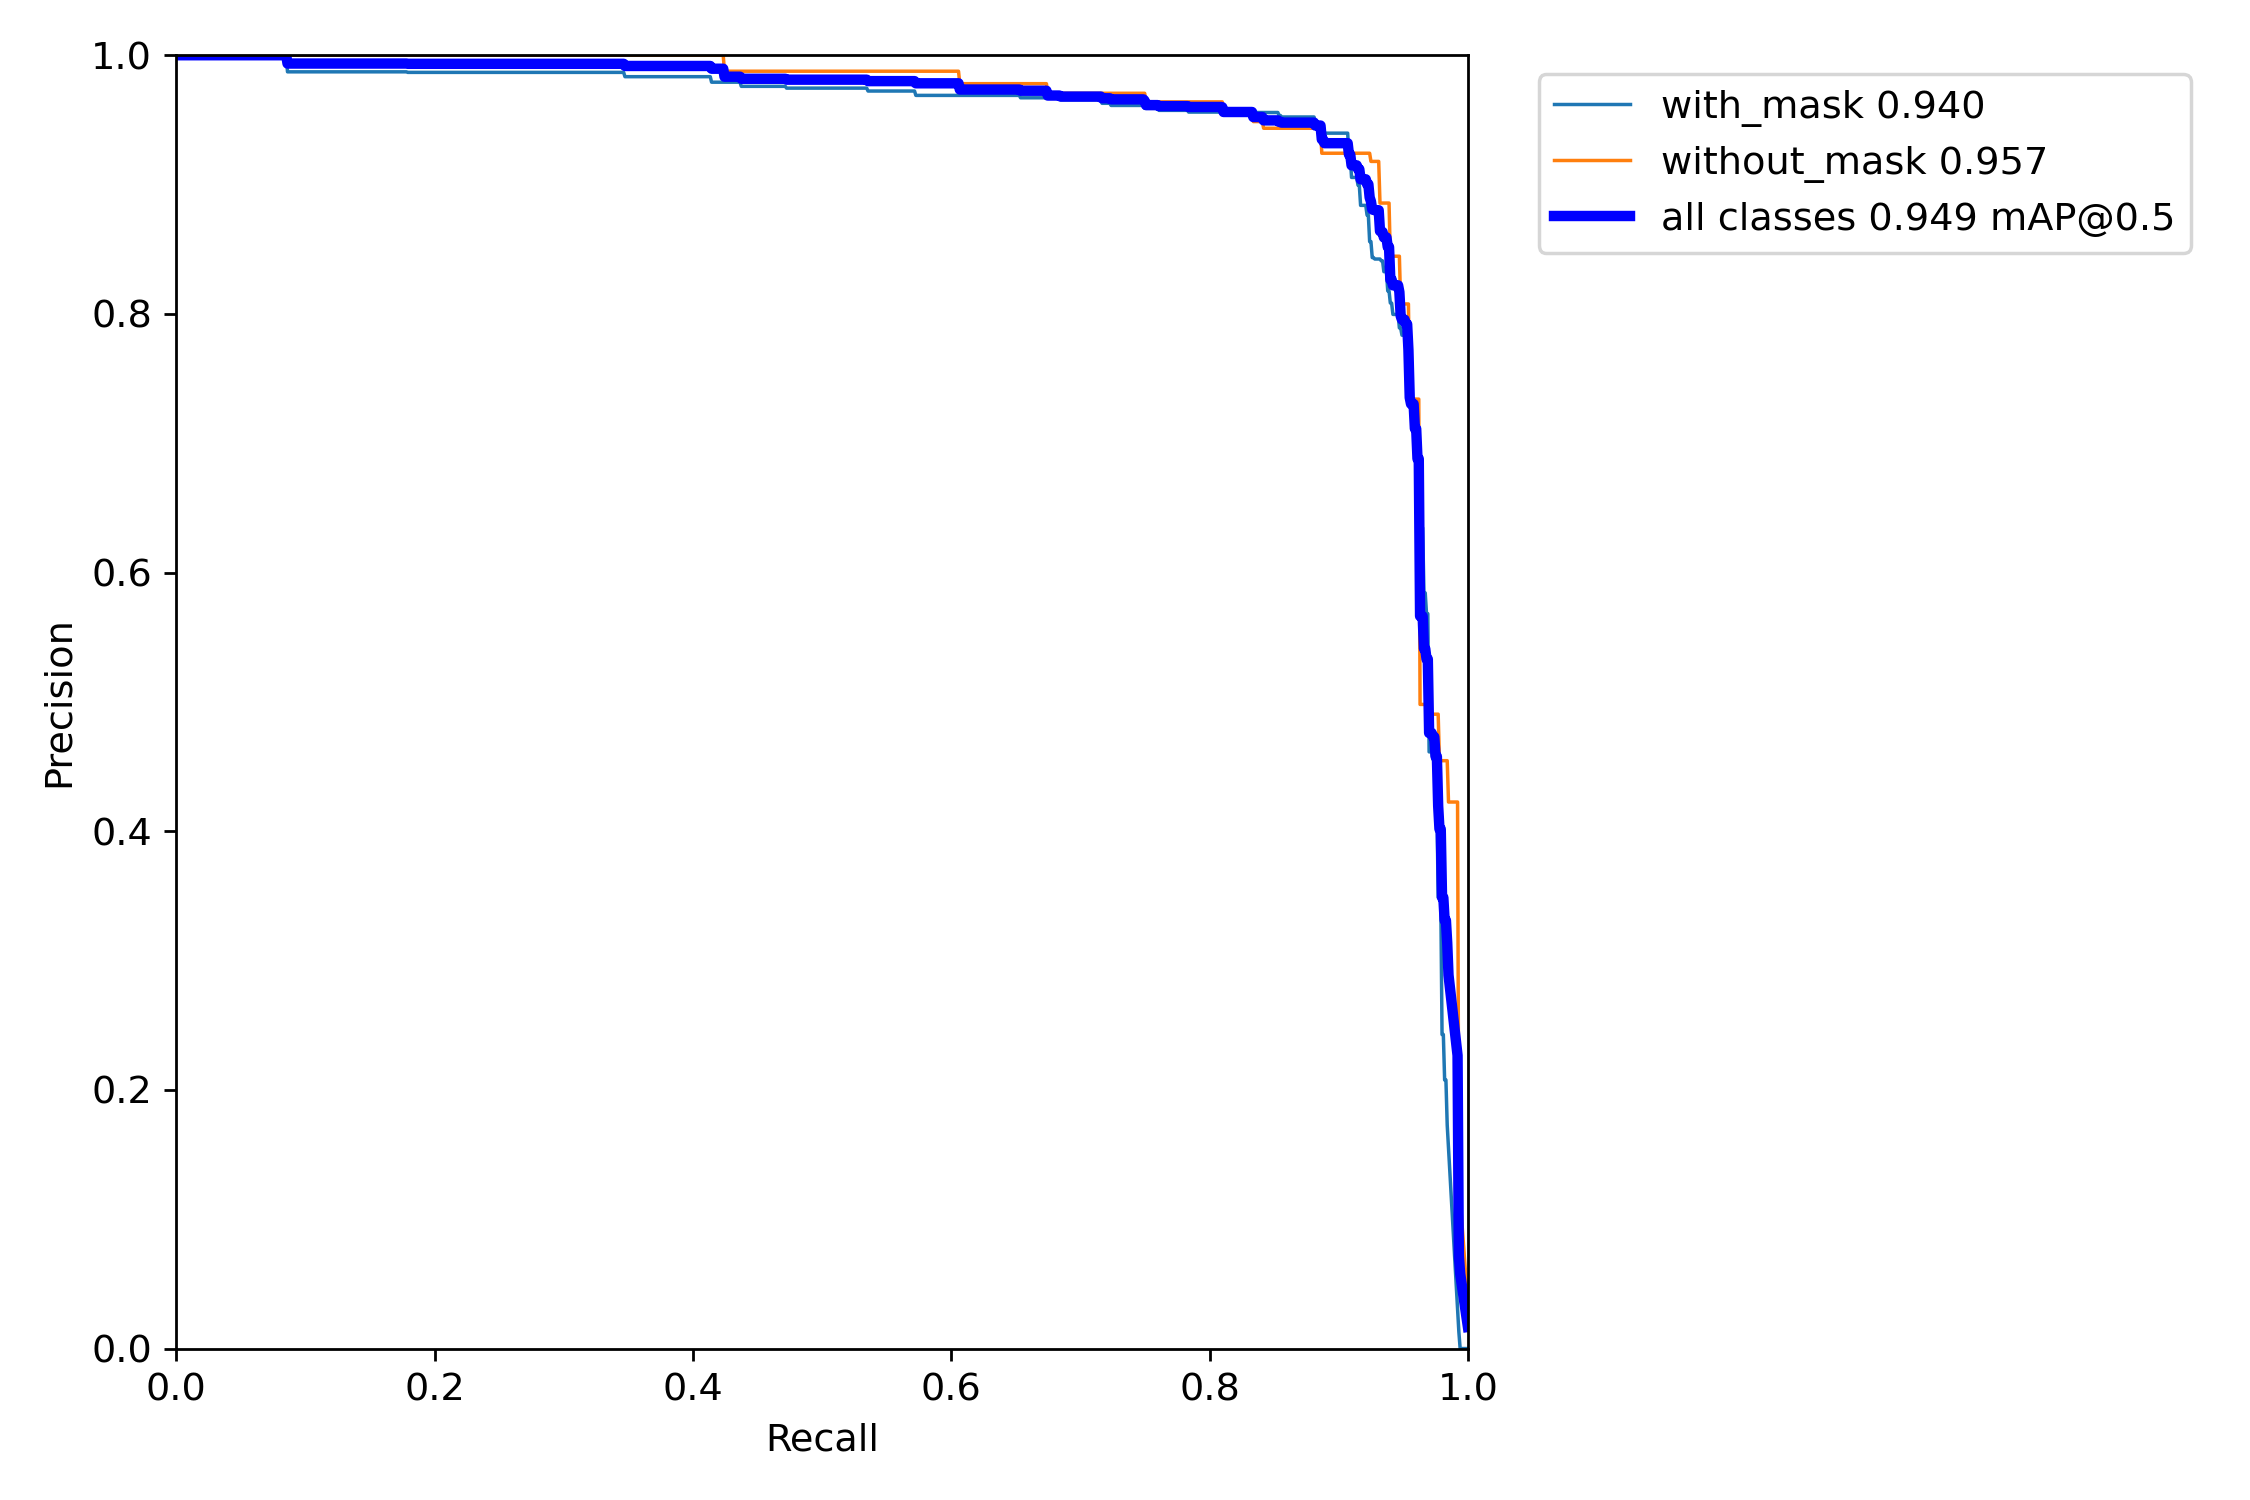

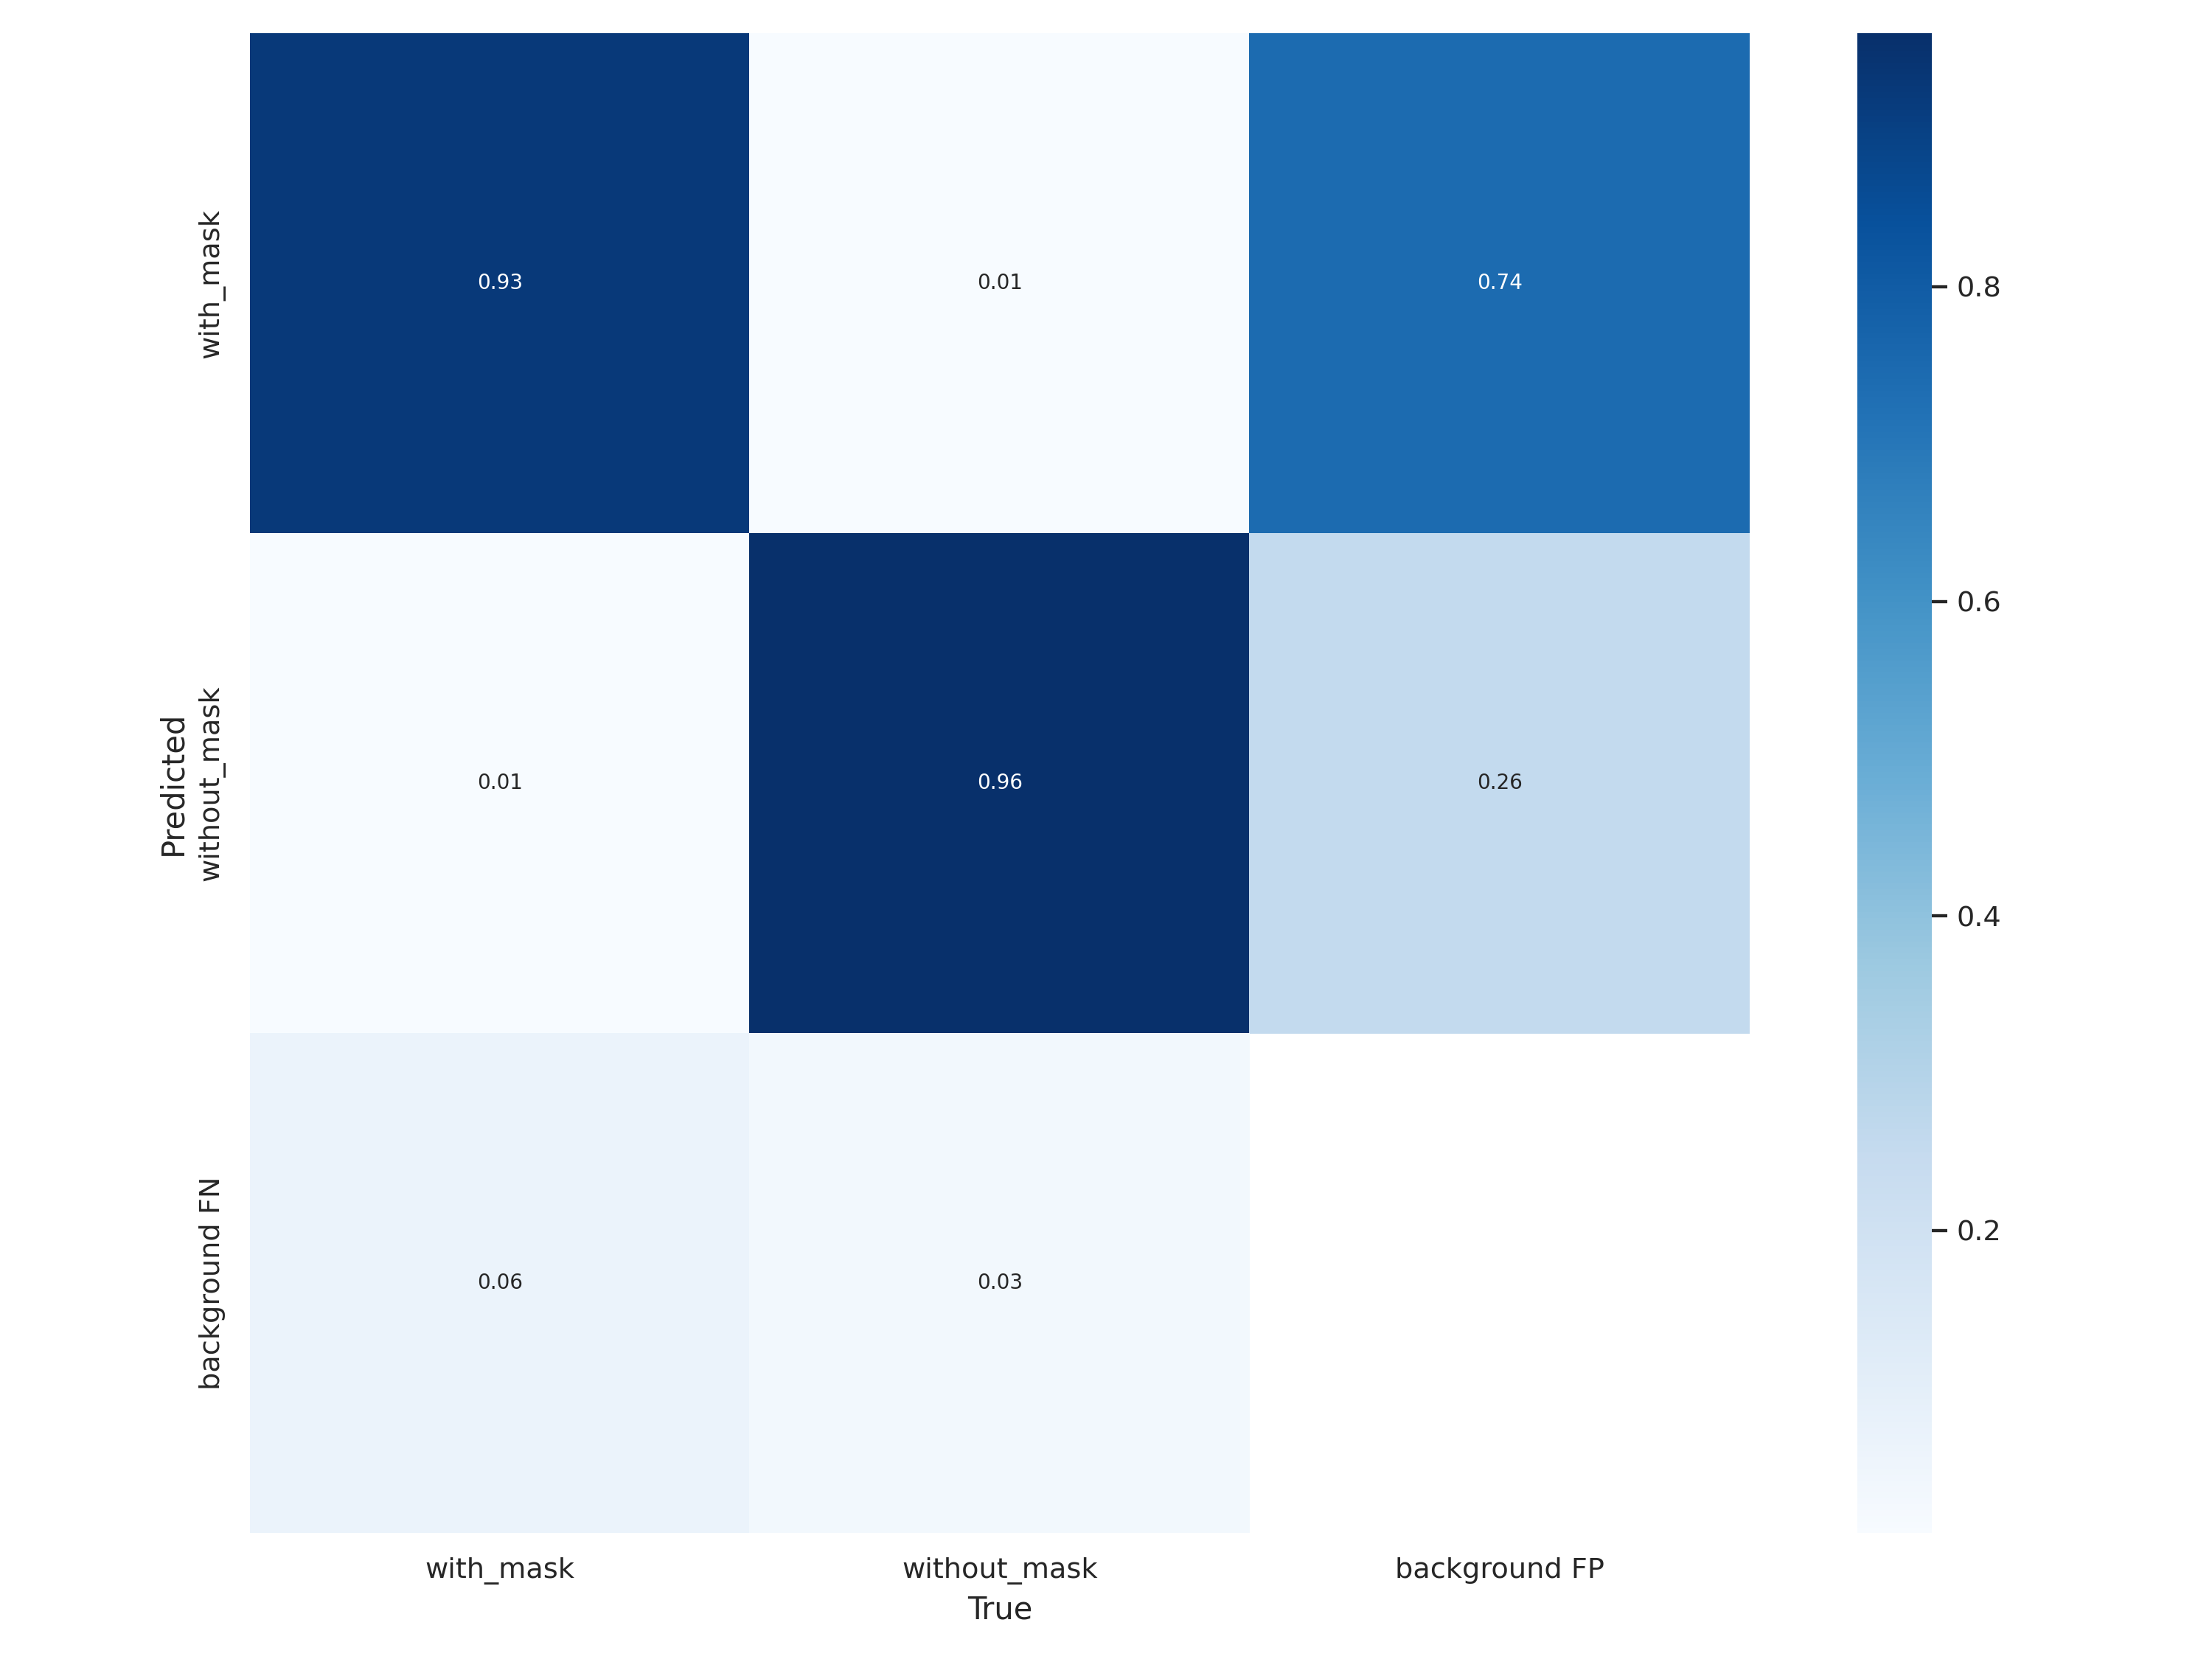

In [ ]:
# Evaluation: F1 and Precision Recall Curve
from IPython.display import Image
display(Image("/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/train/exp/F1_curve.png", width=700, height=500))
display(Image("/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/train/exp/PR_curve.png", width=700, height=500))
display(Image("/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/train/exp/confusion_matrix.png", width=700, height=600))


### Image detecting

In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7')
import argparse
import time
from pathlib import Path
import cv2
import torch
import glob
import PIL
import io
import html
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from IPython.display import HTML
from IPython.display import Image, display
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode
from datetime import datetime

In [ ]:
classes_to_filter = ['with_mask', 'without_mask']
opt = {
    "weights": "/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/train/exp/weights/best.pt", # Path to weights file default weights are for nano model
    "yaml": "Mask_Detection_YOLO_v7-2/data.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres": 0.45, # NMS IoU threshold for inference.
    "device": '0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes": classes_to_filter  # list of classes to filter or None
}

In [ ]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
#Single Image
def detect_single_image(source_image_path):
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    img0 = cv2.imread(source_image_path)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment=False)[0]

    # Apply NMS
    classes = None
    if opt['classes']:
      classes = []
      for class_name in opt['classes']:
        classes.append(opt['classes'].index(class_name))

    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes=classes, agnostic=False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
      
        for *xyxy, conf, cls in reversed(det):

          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
  return img0

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


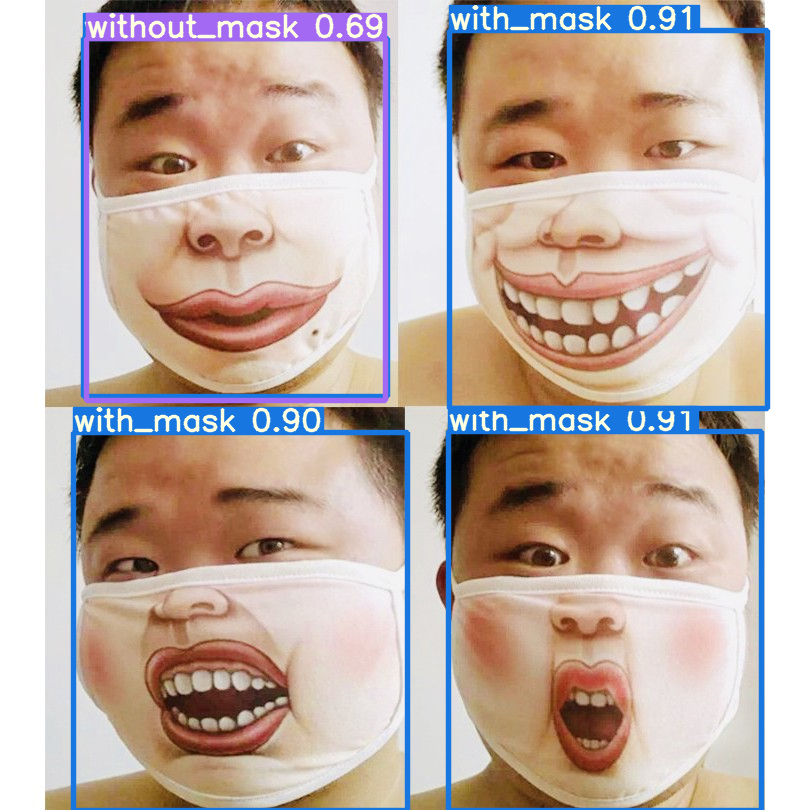

In [ ]:
source_image_path = '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test/b8be244db63a7b7d6fddb5d1b57fa59f.jpg'
cv2_imshow(detect_single_image(source_image_path))

In [ ]:
#Multiple Image
!python detect.py --weights /content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/train/exp/weights/best.pt --conf 0.1 --source /content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test', update=False, view_img=False, weights=['/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/train/exp/weights/best.pt'])
YOLOR 🚀 v0.1-104-g941b94c torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36487166 para

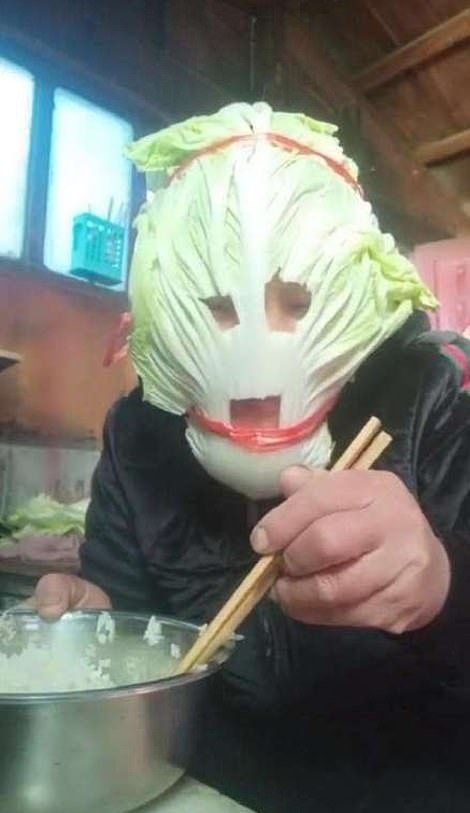

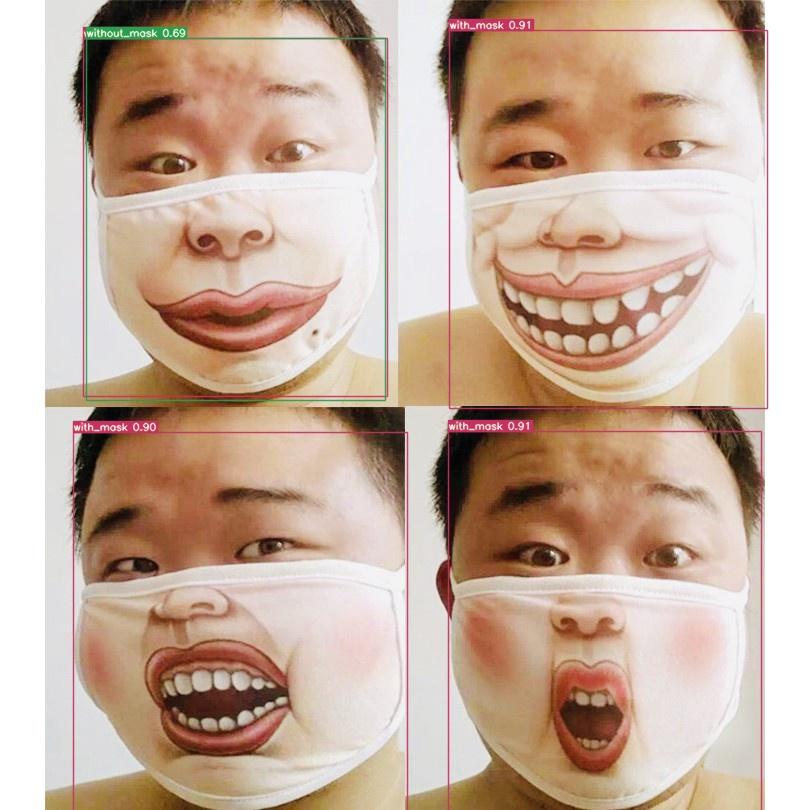

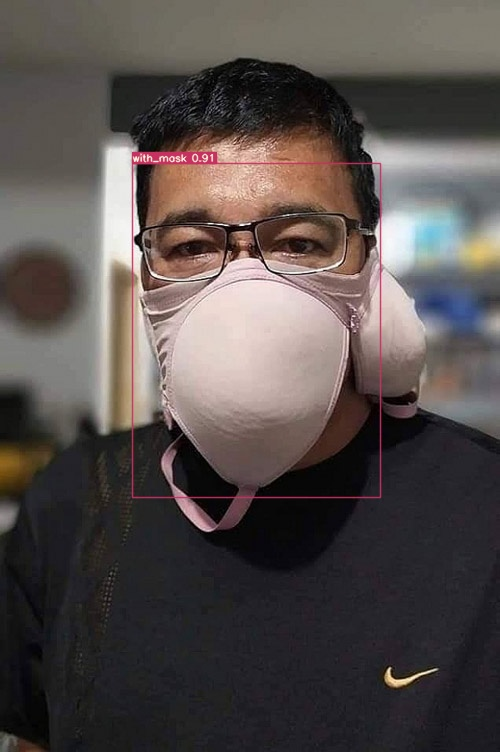

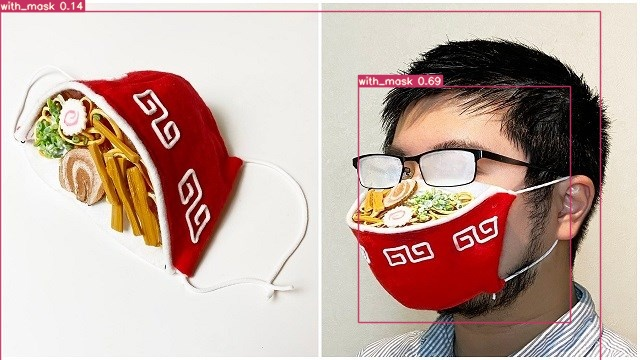

In [ ]:
i = 0
limit = 10000  # max images to print
for imageName in glob.glob('/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/yolov7/runs/detect/exp3/*.jpg'):
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1

### Video detecting

In [ ]:
def detect_video(input_video_path, output_video_path):
  # Initializing video object
  video = cv2.VideoCapture(input_video_path)

  # Video information
  fps = video.get(cv2.CAP_PROP_FPS)
  w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
  h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
  nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

  # Initialzing object for writing video output
  output = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, (w,h))
  torch.cuda.empty_cache()

  # Initializing model and setting it for inference
  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
      model.half()

    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
    if device.type != 'cpu':
      model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

    classes = None
    if opt['classes']:
      classes = []
      for class_name in opt['classes']:
        classes.append(opt['classes'].index(class_name))

    for j in range(nframes):
      ret, img0 = video.read()
      if ret:
        img = letterbox(img0, imgsz, stride=stride)[0]
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
          img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment= False)[0]

        
        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        t2 = time_synchronized()
        for i, det in enumerate(pred):
          s = ''
          s += '%gx%g ' % img.shape[2:]  # print string
          gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
          if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

            for c in det[:, -1].unique():
              n = (det[:, -1] == c).sum()  # detections per class
              s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
    
            for *xyxy, conf, cls in reversed(det):

              label = f'{names[int(cls)]} {conf:.2f}'
              plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)
        
        print(f"{j+1}/{nframes} frames processed")
        output.write(img0)
      else:
        break
    else:
      print('Done!')
  output.release()
  video.release()

In [ ]:
input_video = '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test/video.ts'
output_video = '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test/output.mp4'
detect_video(input_video, output_video)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
1/2689 frames processed
2/2689 frames processed
3/2689 frames processed
4/2689 frames processed
5/2689 frames processed
6/2689 frames processed
7/2689 frames processed
8/2689 frames processed
9/2689 frames processed
10/2689 frames processed
11/2689 frames processed
12/2689 frames processed
13/2689 frames processed
14/2689 frames processed
15/2689 frames processed
16/2689 frames processed
17/2689 frames processed
18/2689 frames processed
19/2689 frames processed
20/2689 frames processed
21/2689 frames processed
22/2689 frames processed
23/2689 frames processed
24/2689 frames processed
25/2689 frames processed
26/2689 frames processed
27/2689 frames processed
28/2689 frames processed
29/2689 frames processed
30/2689 frames processed
31/2689 frames processed
32/2689 frames processed
33/2689 frames processed
34/2689 frames processed
35/2689 frames processed
36/2689 frames processed


In [ ]:
# Input video path
save_path = '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test/output.mp4'
# Compressed video path
compressed_path = "/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test/result_compressed.mp4"
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('''
<video width="800 controls">
      <source src="%s" type="video/mp4">
</video>
''' % data_url)

Output hidden; open in https://colab.research.google.com to view.

### Webcame Detecting

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

### Take photo

In [ ]:
def take_photo(image_path, quality=0.8):
  filename = datetime.now().strftime('%Y%m%d%H%M%S') + '.jpg'
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # save image
  cv2.imwrite(image_path + filename, img)
  # save predicted image
  data_predicted = detect_single_image(image_path + filename)
  img_predicted = 'pred_' + filename
  cv2.imwrite(image_path + img_predicted, data_predicted)
  return img_predicted

<IPython.core.display.Javascript object>

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


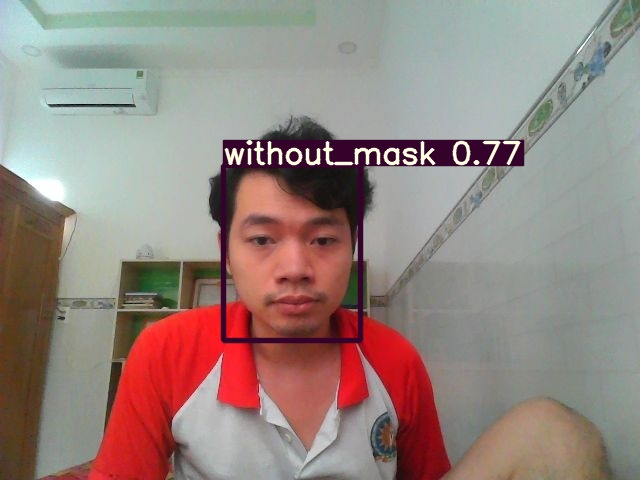

In [ ]:
try:
  image_path = '/content/drive/MyDrive/LDS8_Deep_Learning/Mask_Detection_YOLO_v7/images_test/'
  image = take_photo(image_path)
  display(Image(image_path + image))
except Exception as err:
  print(str(err))

In [ ]:
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [ ]:
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
with torch.no_grad():
  weights, imgsz = opt['weights'], (480,640)
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride

  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz[0], imgsz[1]).to(device).type_as(next(model.parameters())))
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(opt['classes'].index(class_name))
  
  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    
    img0 = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]

    # Apply NMS
    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string
    
        for *xyxy, conf, cls in reversed(det):

          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, bbox_array, label=label, color=colors[int(cls)], line_thickness=3)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
